In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import joblib


In [2]:
import warnings
warnings.filterwarnings('ignore')

## 1. Load the data

In [3]:
df = pd.read_csv('dataset.csv')

## 2. Data Exploration

In [4]:
print(f"Shape: {df.shape}")
print("\nMissing values per column:")
print(df.isnull().sum())

Shape: (17880, 18)

Missing values per column:
job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64


In [5]:
print(df['fraudulent'].value_counts())
print(df['fraudulent'].value_counts(normalize=True).round(3) * 100, '%')

fraudulent
0    17014
1      866
Name: count, dtype: int64
fraudulent
0    95.2
1     4.8
Name: proportion, dtype: float64 %


In [6]:
# Display a few sample rows
print(df.head(2))

   job_id                                      title          location  \
0       1                           Marketing Intern  US, NY, New York   
1       2  Customer Service - Cloud Video Production    NZ, , Auckland   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   

                                         description  \
0  Food52, a fast-growing, James Beard Award-winn...   
1  Organised - Focused - Vibrant - Awesome!Do you...   

                                        requirements  \
0  Experience with content management systems a m...   
1  What we expect from you:Your key responsibilit...   

                                            benefits  telecommuting  \
0                                                NaN              0   
1  What you will get from usThrough being part of...    

## 3. Text Preprocessing

In [7]:
# Download necessary NLTK resources
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

In [8]:
# Function to clean text
def clean_text(text):
    if isinstance(text, str):
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Convert to lowercase and strip
        text = text.lower().strip()
        return text
    else:
        return ''

# Function to remove stopwords and lemmatize
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def process_text(text):
    if isinstance(text, str):
        # Tokenize
        tokens = text.split()
        # Remove stopwords and lemmatize
        processed_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
        return ' '.join(processed_tokens)
    else:
        return ''

# Process text columns
text_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']

for col in text_columns:
    print(f"Processing {col}...")
    df[f'{col}_clean'] = df[col].apply(clean_text)
    df[f'{col}_processed'] = df[f'{col}_clean'].apply(process_text)

Processing title...
Processing company_profile...
Processing description...
Processing requirements...
Processing benefits...


## 4. Feature Engineering

In [9]:
# Combine processed text columns into a single feature
df['all_text'] = df['title_processed'] + ' ' + df['company_profile_processed'] + ' ' + \
                 df['description_processed'] + ' ' + df['requirements_processed'] + ' ' + \
                 df['benefits_processed']

# Create binary features from boolean columns
binary_cols = ['telecommuting', 'has_company_logo', 'has_questions']
for col in binary_cols:
    df[col] = df[col].astype(int)

# Handle categorical columns
cat_cols = ['location', 'department', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']
for col in cat_cols:
    df[col] = df[col].fillna('Unknown')

## 5. Prepare data for modeling

In [10]:
# Define X and y
X_text = df['all_text']
X_categorical = df[cat_cols]
X_numerical = df[binary_cols]
y = df['fraudulent']

In [11]:
# Split data
X_train_text, X_test_text, X_train_cat, X_test_cat, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_text, X_categorical, X_numerical, y, test_size=0.2, random_state=42, stratify=y
)

In [12]:
# TF-IDF for text data
tfidf = TfidfVectorizer(max_features=5000)
X_train_text_tfidf = tfidf.fit_transform(X_train_text)
X_test_text_tfidf = tfidf.transform(X_test_text)

In [13]:
# One-hot encode categorical data
onehot = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X_train_cat_encoded = onehot.fit_transform(X_train_cat)
X_test_cat_encoded = onehot.transform(X_test_cat)

In [14]:
# Combine features
X_train = hstack([X_train_text_tfidf, X_train_cat_encoded, X_train_num])
X_test = hstack([X_test_text_tfidf, X_test_cat_encoded, X_test_num])

## 6. Model Training and Evaluation

In [15]:
# Define models to try
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False)
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f"{name} - Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")
    print(classification_report(y_test, y_pred))

    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'auc': auc,
        'y_pred': y_pred,
        'y_prob': y_prob
    }

Training Logistic Regression...
Logistic Regression - Accuracy: 0.9771, AUC: 0.9870
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3403
           1       0.70      0.91      0.79       173

    accuracy                           0.98      3576
   macro avg       0.85      0.95      0.89      3576
weighted avg       0.98      0.98      0.98      3576

Training Random Forest...
Random Forest - Accuracy: 0.9782, AUC: 0.9913
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       1.00      0.55      0.71       173

    accuracy                           0.98      3576
   macro avg       0.99      0.77      0.85      3576
weighted avg       0.98      0.98      0.98      3576

Training Gradient Boosting...
Gradient Boosting - Accuracy: 0.9810, AUC: 0.9750
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
 

## 7. The best model based on AUC

In [16]:
best_model_name = max(results, key=lambda k: results[k]['auc'])
print(f"\nBest Model: {best_model_name} with AUC: {results[best_model_name]['auc']:.4f}")


Best Model: Random Forest with AUC: 0.9913


## 8. Feature Importance Analysis (for tree-based models)

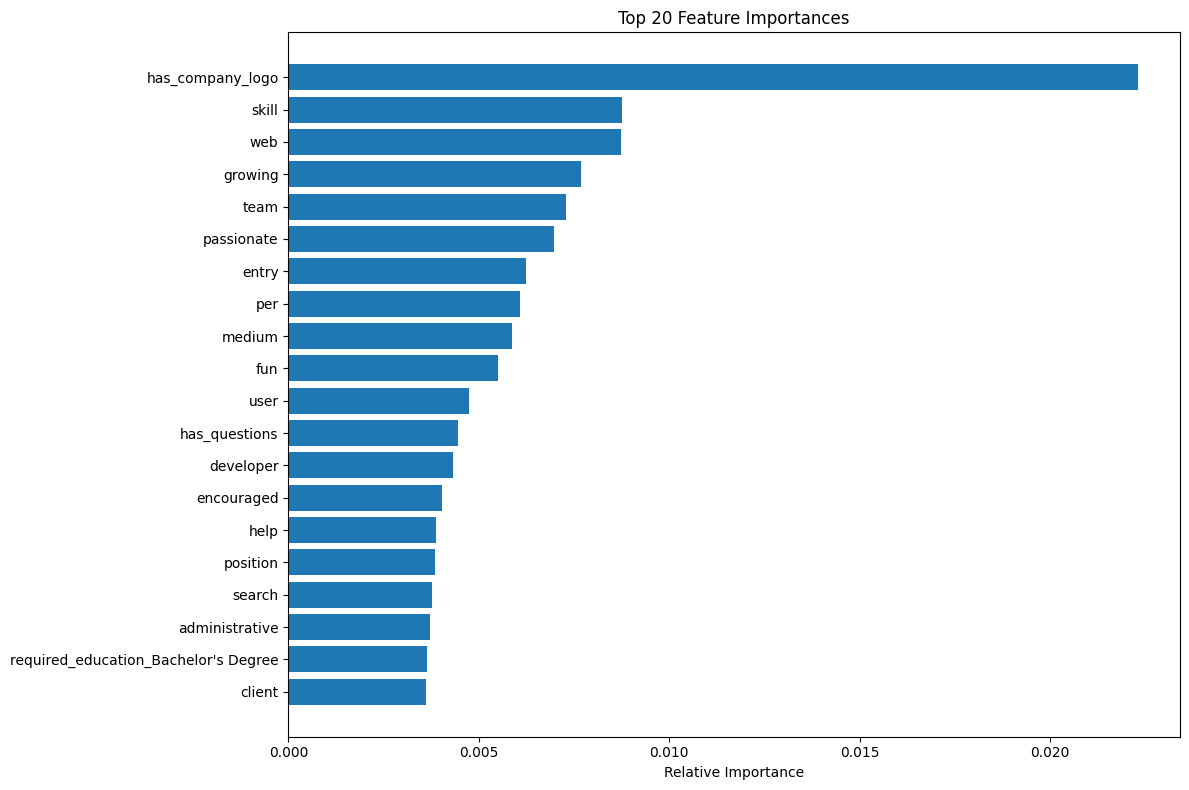

In [17]:
if best_model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost']:
    best_model = results[best_model_name]['model']

    # For tree-based models, we can get feature importances
    if hasattr(best_model, 'feature_importances_'):
        # Get feature names
        feature_names = list(tfidf.get_feature_names_out()) + \
                       list(onehot.get_feature_names_out(cat_cols)) + \
                       binary_cols

        # Limit to top 20 features for visualization
        importances = best_model.feature_importances_
        indices = np.argsort(importances)[-20:]

        plt.figure(figsize=(12, 8))
        plt.title('Top 20 Feature Importances')
        plt.barh(range(20), importances[indices], align='center')
        plt.yticks(range(20), [feature_names[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.tight_layout()
        plt.show()

## 9. ROC Curve Comparison

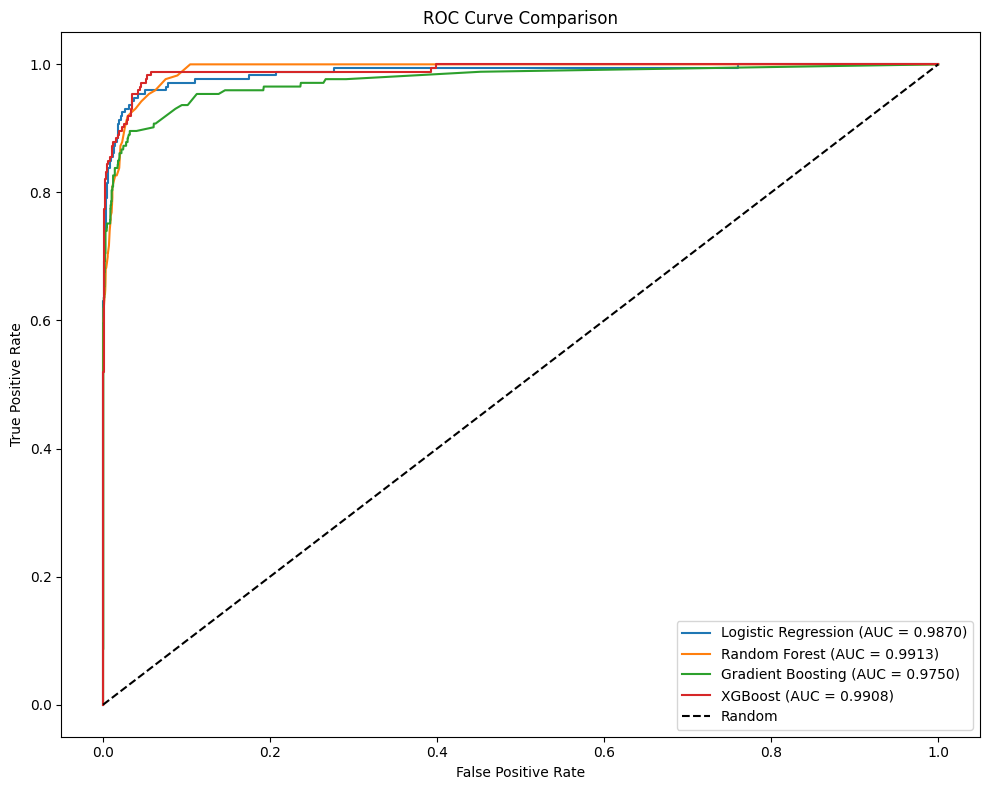

In [18]:
plt.figure(figsize=(10, 8))

for name in results:
    model_results = results[name]
    y_prob = model_results['y_prob']
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {model_results["auc"]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.tight_layout()
plt.show()

## 10. Confusion Matrix for the best model

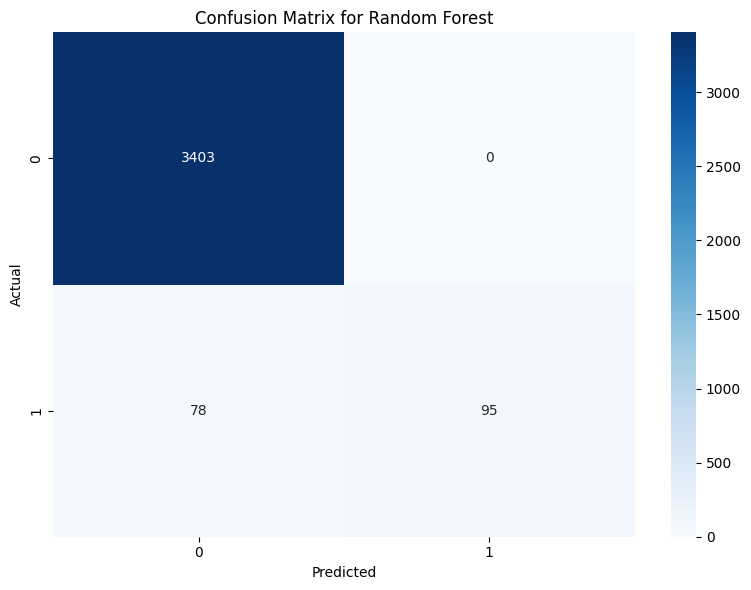

In [19]:
best_y_pred = results[best_model_name]['y_pred']
cm = confusion_matrix(y_test, best_y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.tight_layout()
plt.show()

## 11. Save the best model

In [20]:
joblib.dump(results[best_model_name]['model'], 'fraudulent_job_detector.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(onehot, 'onehot_encoder.pkl')
print("Models and transformers saved!")

Models and transformers saved!


## 12. Hyperparameter tuning for the best model

In [21]:
if best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }
elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
elif best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }

In [22]:
grid_search = GridSearchCV(results[best_model_name]['model'], param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='roc_auc')

In [23]:
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation AUC:", grid_search.best_score_)

Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation AUC: 0.9841826517536075


In [24]:
# Evaluate the tuned model
tuned_model = grid_search.best_estimator_
y_pred_tuned = tuned_model.predict(X_test)
y_prob_tuned = tuned_model.predict_proba(X_test)[:, 1]

In [25]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_prob_tuned):.4f}")
print(classification_report(y_test, y_pred_tuned))

Accuracy: 0.9790
AUC: 0.9918
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       1.00      0.57      0.72       173

    accuracy                           0.98      3576
   macro avg       0.99      0.78      0.86      3576
weighted avg       0.98      0.98      0.98      3576



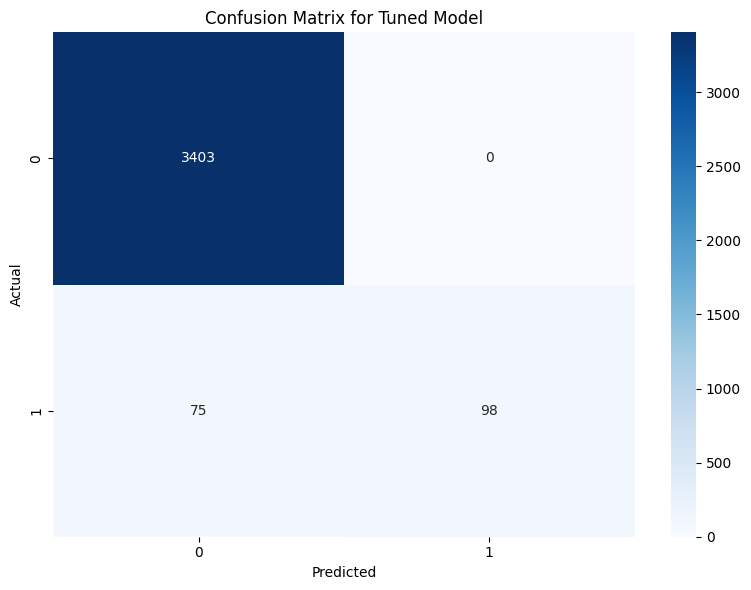

In [26]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_tuned)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Tuned Model')
plt.tight_layout()
plt.show()

In [27]:
# Save the tuned model
joblib.dump(tuned_model, 'tuned_fraudulent_job_detector.pkl')
print("Tuned model saved!")

Tuned model saved!
